<a href="https://colab.research.google.com/github/pinilDissanayaka/Paddy-Doctor-Paddy-Disease-Classification/blob/main/XceptionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install livelossplot
!pip install visualkeras
!pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 35.1 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
! kaggle datasets download ricardosalvatorelli1/paddydoctor

Dataset URL: https://www.kaggle.com/datasets/ricardosalvatorelli1/paddydoctor
License(s): unknown
100% 1.02G/1.02G [01:06<00:00, 19.6MB/s]
100% 1.02G/1.02G [01:06<00:00, 16.4MB/s]


In [4]:
! unzip paddydoctor.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/downy_mildew/100992.jpg  
  inflating: train_images/downy_mildew/100995.jpg  
  inflating: train_images/downy_mildew/101015.jpg  
  inflating: train_images/downy_mildew/101020.jpg  
  inflating: train_images/downy_mildew/101022.jpg  
  inflating: train_images/downy_mildew/101024.jpg  
  inflating: train_images/downy_mildew/101034.jpg  
  inflating: train_images/downy_mildew/101050.jpg  
  inflating: train_images/downy_mildew/101078.jpg  
  inflating: train_images/downy_mildew/101096.jpg  
  inflating: train_images/downy_mildew/101103.jpg  
  inflating: train_images/downy_mildew/101114.jpg  
  inflating: train_images/downy_mildew/101119.jpg  
  inflating: train_images/downy_mildew/101142.jpg  
  inflating: train_images/downy_mildew/101177.jpg  
  inflating: train_images/downy_mildew/101178.jpg  
  inflating: train_images/downy_mildew/101181.jpg  
  inflating: train_images/downy_mildew/101205.jpg  
  inflating: 

In [18]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import cv2
import albumentations as A

from albumentations.core.composition import Compose
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Add, Activation
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from livelossplot import PlotLossesKeras

import warnings
warnings.filterwarnings(action = 'ignore')

In [19]:
import glob
from pathlib import Path

train_path = '/content/train_images'
test_path  = '/content/test_images'

print('train images')
for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

print('test images')
for filepath in glob.glob(test_path + '/*/'):
  files = glob.glob(filepath + '*')
  print(f"{len(files)} \t {Path(filepath).name}")

files = glob.glob(test_path + '/*')
print(f"{len(files)} \t {Path(test_path).name}")

train images
1738 	 blast
1442 	 dead_heart
1088 	 tungro
620 	 downy_mildew
337 	 bacterial_panicle_blight
479 	 bacterial_leaf_blight
965 	 brown_spot
1764 	 normal
1594 	 hispa
380 	 bacterial_leaf_streak
test images
3469 	 test_images


In [20]:
SEED = 123
EPOCHS = 100
lr = 1e-4
valid_split = 0.2
input_size = 224
batch_size = 32

n_classes = len(glob.glob(train_path + '/*/'))
print(n_classes)

10


In [21]:
generator = ImageDataGenerator(rescale=1 / 255,
                                  rotation_range=10,
                                  shear_range=0.25,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  validation_split=valid_split,
#                                   preprocessing_function=get_transforms_train
                                 )

train_datagen = generator.flow_from_directory(train_path,
                                              target_size=(input_size, input_size),
                                              batch_size=batch_size,
                                              subset='training',
                                              seed=SEED)

valid_datagen = generator.flow_from_directory(train_path,
                                              target_size=(input_size, input_size),
                                              batch_size=batch_size,
                                              subset='validation',
                                              seed=SEED)

test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(directory=test_path,
                                                                    target_size=(input_size, input_size),
                                                                    batch_size=batch_size,
                                                                    #classes=['.'],
                                                                    shuffle=False,
                                                                    seed=SEED
                                                                   )

print(train_datagen.class_indices)
print(train_datagen.samples, valid_datagen.samples, test_generator.samples, )

Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.
Found 0 images belonging to 0 classes.
{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}
8330 2077 0


In [22]:
def create_model(input_size, n_classes):
    back_bone = tf.keras.applications.Xception(weights='imagenet', input_shape=(input_size,input_size,3), include_top=False)
    back_bone.summary()
    input_layer = Input(shape=(input_size,input_size,3))
    x = back_bone(input_layer)
    x = GlobalAveragePooling2D()(x)
    output_layer = Dense(n_classes, activation='softmax')(x)

    initializer = tf.keras.initializers.HeUniform()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.categorical_crossentropy

    model = Model(input_layer,output_layer)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    return model

model = create_model(input_size, n_classes)
model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,881,970 (79.66 MB)

 Trainable params: 20,827,442 (79.45 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [23]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=15,
                                              monitor='val_loss',
                                              restore_best_weights=True,
                                              verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=5,
                                                 monitor='val_loss',
                                                 factor=0.75,
                                                 verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='xception.weights.best.keras',
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

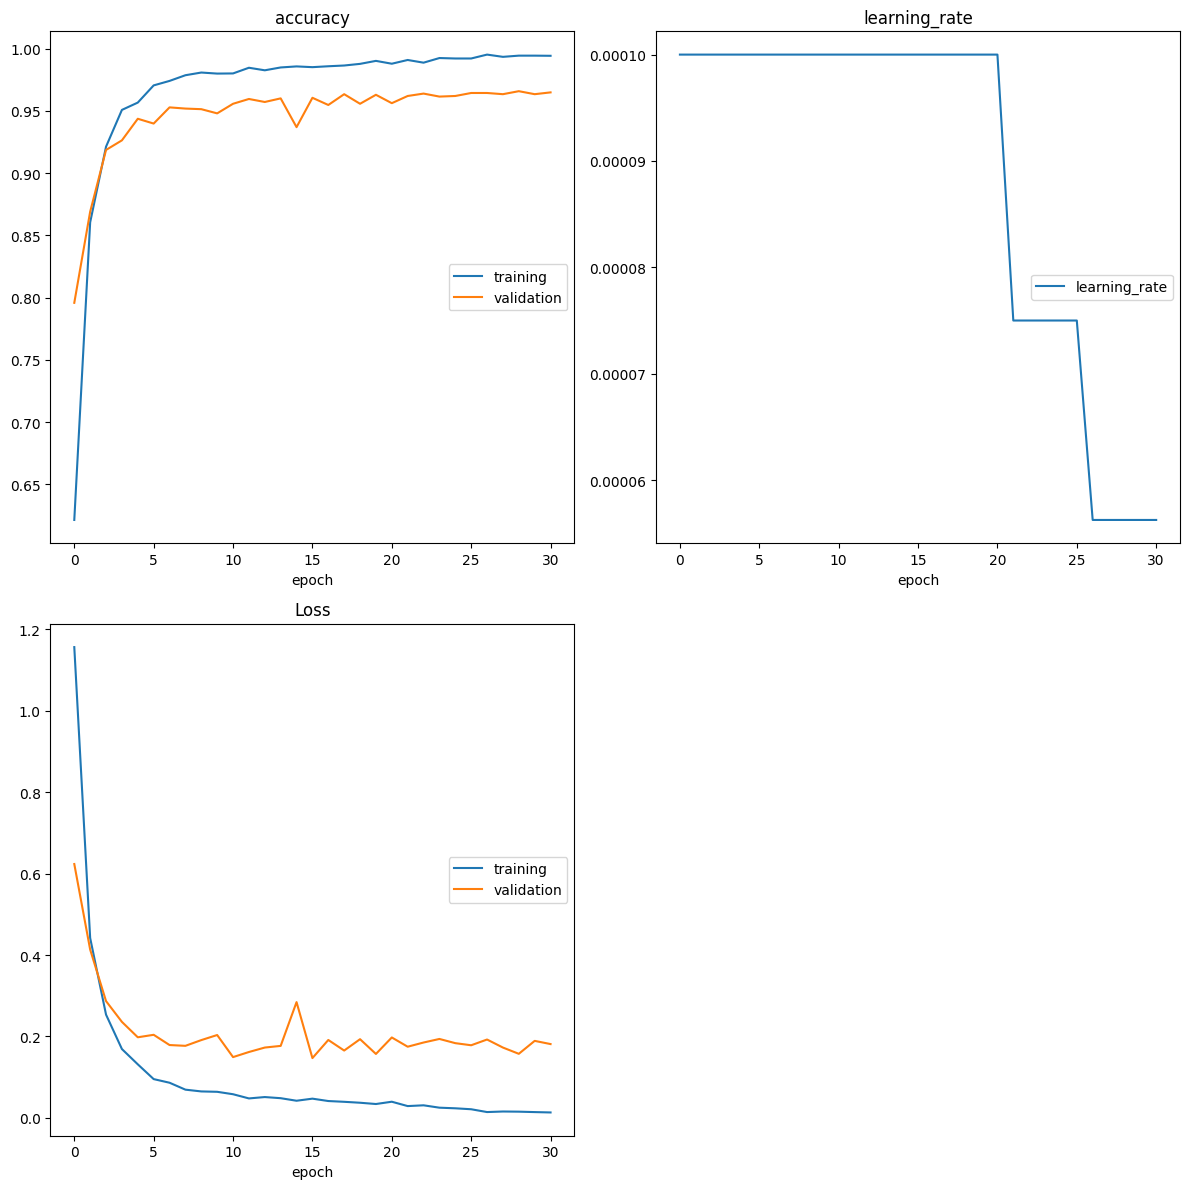

accuracy
	training         	 (min:    0.621, max:    0.995, cur:    0.994)
	validation       	 (min:    0.796, max:    0.966, cur:    0.965)
learning_rate
	learning_rate    	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:    0.013, max:    1.157, cur:    0.013)
	validation       	 (min:    0.147, max:    0.624, cur:    0.181)
261/261 ━━━━━━━━━━━━━━━━━━━━ 182s 682ms/step - accuracy: 0.9945 - loss: 0.0128 - val_accuracy: 0.9649 - val_loss: 0.1813 - learning_rate: 5.6250e-05
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 16.


In [24]:
history = model.fit(train_datagen,
                    validation_data=valid_datagen,
                    batch_size=batch_size,
                    epochs=EPOCHS,
                    callbacks=[early_stop,reduce_lr, checkpoint, PlotLossesKeras()])

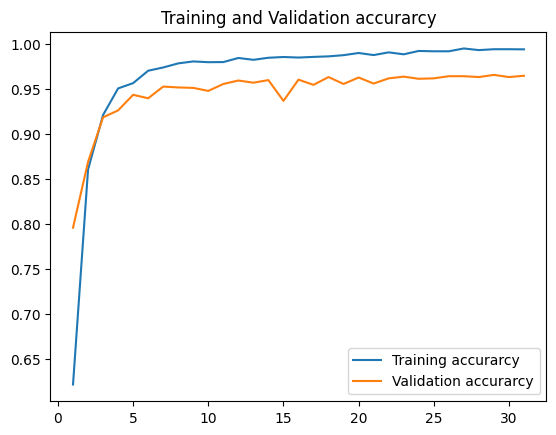

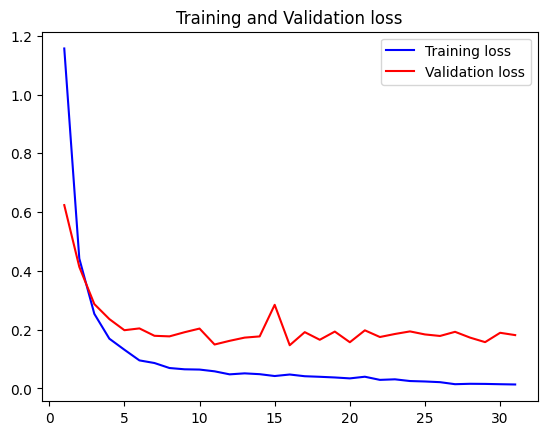

CPU times: user 464 ms, sys: 194 ms, total: 658 ms
Wall time: 474 ms


In [25]:
%%time
temp = pd.DataFrame(history.history)
temp.to_csv('model_xception_history.csv', index=False)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, label='Training accurarcy')
plt.plot(epochs, val_acc, label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [33]:
print('test images')
for filepath in glob.glob(train_path+'/*'):
    files = glob.glob(filepath + '/*')
    print(f"{len(files)} \t {Path(filepath).name}")

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    #classes=['.'],
    #class_mode="categorical",
    class_mode=None,
    shuffle=False,
    seed=SEED)

test images
1738 	 blast
1442 	 dead_heart
1088 	 tungro
620 	 downy_mildew
337 	 bacterial_panicle_blight
479 	 bacterial_leaf_blight
965 	 brown_spot
1764 	 normal
1594 	 hispa
380 	 bacterial_leaf_streak
Found 10407 images belonging to 10 classes.


In [29]:
model.load_weights('xception.weights.best.keras')

In [34]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
#test_generator.reset()

pred = model.predict(test_generator,
                    steps=STEP_SIZE_TEST,
                    verbose=1)

pred_classes = np.argmax(pred, axis=1)

10407/10407 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step


In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

class_names = test_generator.class_indices.keys()
true_classes = test_generator.classes

acc = accuracy_score(true_classes, pred_classes)
print("xception Model Accuracy : {:.2f}%".format(acc * 100))

cls_report = classification_report(true_classes, pred_classes,
                                   target_names=class_names, digits=5)
print(cls_report)

xception Model Accuracy : 98.76%
                          precision    recall  f1-score   support

   bacterial_leaf_blight    0.98330   0.98330   0.98330       479
   bacterial_leaf_streak    0.97668   0.99211   0.98433       380
bacterial_panicle_blight    0.98225   0.98516   0.98370       337
                   blast    0.98394   0.98734   0.98564      1738
              brown_spot    0.98657   0.98964   0.98810       965
              dead_heart    0.99584   0.99653   0.99619      1442
            downy_mildew    0.99000   0.95806   0.97377       620
                   hispa    0.98809   0.98871   0.98840      1594
                  normal    0.98588   0.98923   0.98755      1764
                  tungro    0.99170   0.98805   0.98987      1088

                accuracy                        0.98760     10407
               macro avg    0.98642   0.98581   0.98609     10407
            weighted avg    0.98762   0.98760   0.98759     10407



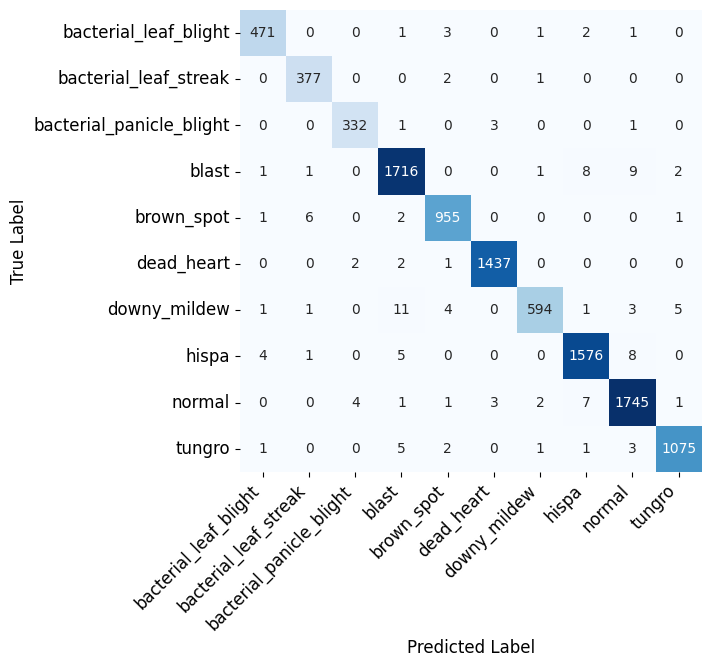

[[ 471    0    0    1    3    0    1    2    1    0]
 [   0  377    0    0    2    0    1    0    0    0]
 [   0    0  332    1    0    3    0    0    1    0]
 [   1    1    0 1716    0    0    1    8    9    2]
 [   1    6    0    2  955    0    0    0    0    1]
 [   0    0    2    2    1 1437    0    0    0    0]
 [   1    1    0   11    4    0  594    1    3    5]
 [   4    1    0    5    0    0    0 1576    8    0]
 [   0    0    4    1    1    3    2    7 1745    1]
 [   1    0    0    5    2    0    1    1    3 1075]]


In [36]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_classes, pred_classes, class_names, ax, title="CNN")

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()
cm = confusion_matrix(true_classes, pred_classes)
print(cm)

In [39]:
_ = model.predict(test_generator, steps=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


In [41]:
loss, acc = model.evaluate(test_generator, steps=STEP_SIZE_TEST, verbose=1)
print(acc, loss)

ValueError: None values not supported.

In [46]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_datagen.class_indices)

labels = (train_datagen.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

pd.Series(predictions).value_counts()

,count
normal,1770
blast,1744
hispa,1595
dead_heart,1443
tungro,1084
brown_spot,968
downy_mildew,600
bacterial_leaf_blight,479
bacterial_leaf_streak,386
bacterial_panicle_blight,338


In [47]:
filenames=test_generator.filenames

results=pd.DataFrame({"image_id":filenames,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submission.csv",index=False)
results.head()

,image_id,label
0,bacterial_leaf_blight/100023.jpg,bacterial_leaf_blight
1,bacterial_leaf_blight/100049.jpg,bacterial_leaf_blight
2,bacterial_leaf_blight/100126.jpg,bacterial_leaf_blight
3,bacterial_leaf_blight/100133.jpg,bacterial_leaf_blight
4,bacterial_leaf_blight/100148.jpg,bacterial_leaf_blight


In [48]:
labels=labels
model=model

In [49]:
import pickle

with open('model_labels.pkl', 'wb') as file:
    pickle.dump(labels, file)

In [50]:
from tensorflow.keras.models import save_model
save_model(model, "model.keras")

In [51]:
from tensorflow.keras.models import load_model

# load model
model1 = load_model('model.keras')

In [52]:
model1.weights

[<KerasVariable shape=(3, 3, 3, 32), dtype=float32, path=block1_conv1/kernel>,
 <KerasVariable shape=(32,), dtype=float32, path=block1_conv1_bn/gamma>,
 <KerasVariable shape=(32,), dtype=float32, path=block1_conv1_bn/beta>,
 <KerasVariable shape=(32,), dtype=float32, path=block1_conv1_bn/moving_mean>,
 <KerasVariable shape=(32,), dtype=float32, path=block1_conv1_bn/moving_variance>,
 <KerasVariable shape=(3, 3, 32, 64), dtype=float32, path=block1_conv2/kernel>,
 <KerasVariable shape=(64,), dtype=float32, path=block1_conv2_bn/gamma>,
 <KerasVariable shape=(64,), dtype=float32, path=block1_conv2_bn/beta>,
 <KerasVariable shape=(64,), dtype=float32, path=block1_conv2_bn/moving_mean>,
 <KerasVariable shape=(64,), dtype=float32, path=block1_conv2_bn/moving_variance>,
 <KerasVariable shape=(3, 3, 64, 1), dtype=float32, path=block2_sepconv1/depthwise_kernel>,
 <KerasVariable shape=(1, 1, 64, 128), dtype=float32, path=block2_sepconv1/pointwise_kernel>,
 <KerasVariable shape=(128,), dtype=float

In [16]:
pip install --upgrade tensorflow

In [17]:
import tensorflow as tf
print(tf.__version__)

2.17.0
